# Step44, 매개변수를 모아두는 계층 

이전 단계에서 DeZero를 사용하여 신경망을 구현하였다. DeZero를 '신경망 프레임워크'라고 할수 있다.

이번 단계에서는 매개변수를 다룬다.  
이전 단계에서는 매개변수의 기울기를 재설정할때(or 매개변수를 갱신할 때) 다소 단조로운 코드를 작성해야 했다.  
앞으로 더욱 복잡한 신경망을 구현하면 매개변수를 다루는 일도 그만큼 복잡해진다.

매개변수는 경사하강법 등의 최적화 기법에 의해 갱신되는 변수이다.  
예: '가중치', '편향'이 매개변수에 해당 

이번 단계에서는 매개변수를 담는 구조를 만든다.  
Parameter와 Layer 클래스 구현  
이 두 클래스를 사용하면 매개변수 관리를 자동화할 수 있다.

## 44.1 Parameter 클래스 구현 

Parameter 클래스는 Variable 클래스와 똑같은 기능을 갖게한다.  
Variable 클래스를 상속한게 다라서 기능도 Variable 클래스와 동일하다.

Parameter 클래스는 core.py에 추가  
__init__.py에 from dezero.core import Parameter 추가 

In [1]:
from dezero import Variable

In [2]:
# core.py
class Parameter(Variable):
    pass

Parameter 인스턴스와 Variable 인스턴스는 기능은 같지만 구별할수 있다.

In [3]:
import numpy as np 
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(1.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


이와같이 Parameter 인스턴스와 Variable 인스턴스를 조합하여 계산할 수 있다.  
또한 isinstance 함수로 구분할 수 있다.  

이 점을 이용하여 Parameter 인스턴스만을 담는 구조를 만들 수 있다.

## 44.2 Layer 클래스 구현 

Layer는 Function 클래스와 마찬가지로 변수를 변환하는 클래스이다.  
그러나 매개변수를 유지한다는 점이 다르다.  
Layer 클래스는 매개변수를 유지하고 매개변수를 사용하여 변환을 하는 클래스 

**NOTE_** Layer 클래스를 기반 클래스로 두고 구체적인 변환은 자식 클래스에서 구현한다.  
예를 들어 선형 변환은 Layer 클래스를 상속한 Linear 클래스에서 구현한다.

In [4]:
# layers.py
from dezero.core import Parameter 

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

Layer 클래스에는 \_params라는 인스턴스 변수가 있다.  
\_params 에는 Layer 인스턴스에 속한 매개변수를 보관한다.

**CAUTION_** 인스턴스 변수 _params의 타입은 '집합(set)'이다.  
집합은 리스트와 달리 원소들에 순서가 없고 ID가 같은 객체는 종복 저장할 수 없다.

\__setattr\__은 인스턴스 변수를 설정할 때 호출되는 특수 메서드이다.  
\__setattr\__(self, name, value)는 이름이 name인 인스턴스 변수에 값으로 value를 전달해준다.  
이 메서드를 재정의(override)하면 인스턴스 변수를 설정할 때 자신만의 로직을 추가할 수 있다.

여기에서는 value가 Parameter 인스턴스라면 self._params에 name을 추가한다  
이렇게 하여 Layer 클래스가 갖는 매개변수를 인스턴스 변수 _params에 모아둘 수 있다.


In [5]:
from dezero.core import Parameter

class Layer:
    def __init__(self):
        self._params = set()    # Layer 인스턴스에 속한 매개변수를 보관한다.

    def __setattr__(self, name, value): # 이름이 name인 인스턴스 변수에 값으로 value를 전달해준다.
        if isinstance(value, Parameter):
            self._params.add(name)      # value가 Parameter 인스턴스라면 self._params에 name을 추가한다.
        super().__setattr__(name, value)

layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('-----------------')

for name in layer._params:
    print(name, layer.__dict__[name])

{'p2', 'p1'}
-----------------
p2 variable(2)
p1 variable(1)


layer 인스턴스 변수를 설정하면,  
Parameter 인스턴스를 보유하고 있는 인스턴스 변수 이름만 layer._params에 추가된다.

\__dict\__에는 모든 인스턴스 변수가 딕셔너리(dictionary)타입으로 저장되기 때문에 Parameter 인스턴스만 꺼낼 수 있다.

In [6]:
from dezero.core import Parameter
import weakref 

class Layer:
    def __init__(self):
        self._params = set()    # Layer 인스턴스에 속한 매개변수를 보관한다.

    def __setattr__(self, name, value): # 이름이 name인 인스턴스 변수에 값으로 value를 전달해준다.
        if isinstance(value, Parameter):
            self._params.add(name)      # value가 Parameter 인스턴스라면 self._params에 name을 추가한다.
        super().__setattr__(name, value)
    
    def __call__(self, *inputs):    # __call__ 메서드는 입력받은 인수를 건네 forward 메서드를 호출한다
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]      # 입력과 출력 변수를 약한 참조로 유지
        self.outputs = [weakref.ref(x) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]  # 출력이 하나뿐이면 튜플이 아니라 그 출력 하나를 직접 반환한다.
    
    def forward(self, inputs):      # forward 메서드는 자식클래스에서 구현할 것이다.
        raise NotImplementedError()

    def params(self):
        for name in self._params:       # Layer 인스턴스에 담겨있는 Parameter 인스턴스들을 꺼내준다.
            yield self.__dict__[name]   # yield는 return처럼 사용할 수 있다.
        
    def cleargrads(self):               # 모든 매개변수의 기울기를 재설정한다.
        for param in self.params():
            param.cleargrad()

**NOTE_** params 메서드는 yield를 사용하여 값을 반환한다.  
yield는 return처럼 사용할 수 있다.  

return은 처리를 종료하고 값을 반환  
yield는 처리를 '일시중지(suspend)'하고 값을 반환한다. 따라서 yield를 사용하면 작업을 재개(resume)할 수 있다.  
params 메서드를 호출할 때마다 일시중지됐던 처리가 재개된다.

이런식으로(yield를 for문과 함께 사용하여) 매개변수를 순차적으로 꺼낼 수 있다.

## 44.3 Linear 클래스 구현 

함수로서의 Linear 클래스가 아니라 계층으로서의 Linear 클래스를 구현한다.  
간단한 Linear 클래스

In [7]:
import numpy as np 
import dezero.functions as F 
from dezero.core import Parameter

class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):  # 입력크기, 출력크기, 편향사용여부
        super().__init__()

        I, O = in_size, out_size
        W_data = np.random.randn(I,O).astype(dtype) * np.sqrt(1/I)  # (0.01 * np.random.randn()대신)
        self.W = Parameter(W_data, name='W')
        if nobias:
            self.b = None 
        else:
            self.b = Parameter(np.zeros(0, dtype=dtype), name='b')
        # self.W와 self.b가 Parameter 형태로, 두 Parameter 인스턴스 변수의 이름이 self._params에 추가된다.
    
    def forward(self, x):               # 선형 변환 구현
        y = F.linear(x, self.W, self.b)
        return y 

Linear 클래스의 가중치 초기값은 무작위로 설정해야 한다.  
신경망의 계산은 32비트 부동소수점을 써도 문제가 없다고 한다.

Linear 클래스를 구현하는 더 나은 방법  
가중치 W를 생성하는 시점을 늦추는 방법

가중치를(초기화 메서드가 아닌) forward 메서드에서 생성함으로써 Linear 클래스의 입력 크기(in_size)를 자동으로 결정할 수 있다.  

개선된 Linear 클래스를 살펴보자.

In [8]:
# layers.py
import numpy as np 
import dezero.functions as F 
from dezero.core import Parameter

class Linear(Layer):
    # def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):  # 입력크기, 출력크기, 편향사용여부
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size      # <- 추가 
        self.out_size = out_size    # <- 추가
        self.dtype = dtype          # <- 추가

        # I, O = in_size, out_size
        # W_data = np.random.randn(I,O).astype(dtype) * np.sqrt(1/I)  # (0.01 * np.random.randn()대신)
        # self.W = Parameter(W_data, name='W') # 아래 코드로 바뀜 
        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()
        if nobias:
            self.b = None 
        else:
            # self.b = Parameter(np.zeros(0, dtype=dtype), name='b')
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')
        # self.W와 self.b가 Parameter 형태로, 두 Parameter 인스턴스 변수의 이름이 self._params에 추가된다.
    
    # 추가
    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data  
    
    def forward(self, x):               # 선형 변환 구현
        # 데이터를 흘려보내는 시점에 개충치 초기화 
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()

        y = F.linear(x, self.W, self.b)
        return y 

위 코드가 개선된 Linear 클래스  
\__init\__ 메서드에서 in_size를 지정하지 않아도 된다.  

인수 in_size는 기본적으로 None으로 지정  
None인 경우 self.W.data 초기화를 '연기'한다.  

forward(self, x) 메서드에서 입력 x의 크기에 맞게 가중치 데이터를 생성하는 것이다.  
이제 layer = Linear(100) 처럼 출력 크기만 지정해도 된다.

## 44.4 Layer를 이용한 신경망 구현 


variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126008)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.1231190572064935)
variable(0.0788816650635515)
variable(0.07655073683421633)
variable(0.07637803086238226)
variable(0.07618764131185571)


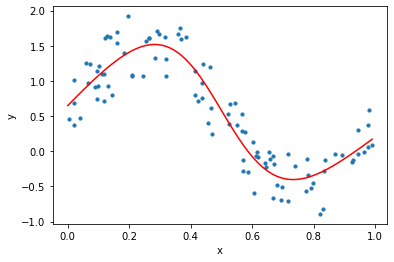

In [9]:
import numpy as np 
from dezero import Variable
import dezero.functions as F 
import dezero.layers as L 
import matplotlib.pyplot as plt

# 데이터셋 
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1)

l1 = L.Linear(10)   # 출력 크기 지정 
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y 

lr = 0.2 
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1,l2]:
        for p in l.params():
            p.data -= lr * p.grad.data 
    
    if i % 1000 == 0:
        print(loss)


# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()